In [ ]:
%%capture
!pip install lightautoml

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 1luhGPR0zWXCmVAsa5tA74e5z9FE63y3F

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1luhGPR0zWXCmVAsa5tA74e5z9FE63y3F
To: /content/big_df.csv
100% 1.48G/1.48G [00:09<00:00, 149MB/s]


In [ ]:
!gdown --id 1IwFMbWJNUU1G-UkbjpOAq8jAYpCZrLfM

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1IwFMbWJNUU1G-UkbjpOAq8jAYpCZrLfM
To: /content/train_clusters.csv
100% 62.0M/62.0M [00:00<00:00, 96.7MB/s]


In [ ]:
!gdown --id 1mM1Jt3HcwfEx6lVsqbwHiVFQJuW28WV6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1mM1Jt3HcwfEx6lVsqbwHiVFQJuW28WV6
To: /content/PIndx20.csv
100% 7.70M/7.70M [00:00<00:00, 52.9MB/s]


In [ ]:
!gdown --id 1qko7C-EEk1Smf9dB46iSc7DU5kEKIp87

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1qko7C-EEk1Smf9dB46iSc7DU5kEKIp87
To: /content/test_dataset_test.csv
100% 656M/656M [00:05<00:00, 117MB/s]


In [ ]:
!gdown --id 14mCgEKtF_Z-p6qLkvs-ovM1WtilHy_N-

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=14mCgEKtF_Z-p6qLkvs-ovM1WtilHy_N-
To: /content/test_clusters.csv
100% 40.9M/40.9M [00:00<00:00, 107MB/s] 


In [ ]:

# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task


In [ ]:

pd.set_option('display.max_columns', None)

In [ ]:
big_df = pd.read_csv('./big_df.csv')

In [ ]:
#del big_df

In [ ]:
N_THREADS = 32
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900*4*2 # equal to 15*4 minutes
TARGET_NAME = 'label'

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
big_df['net_weight'] = (big_df['weight'] - big_df['weight_mfi'])
big_df['total_price'] = (big_df['price_mfi'] + big_df['transport_pay'])

big_df['w/p'] = np.log(big_df['weight_mfi'] + 1) - np.log(big_df['price_mfi']+1)

big_df['post_days'] = pd.to_datetime('2020-11-1') - pd.to_datetime(big_df['ACTDATE'])
big_df['post_days'] = big_df['post_days'].apply(lambda x: x.days)


big_df['delta_log1'] = np.log(big_df['total_qty_oper_login_1']+1) - np.log(big_df['dist_qty_oper_login_1']+1)

big_df['delta_qty_log'] = (big_df['total_qty_oper_login_1'] - big_df['total_qty_oper_login_0'])

big_df['delta_bigi'] = (big_df['total_qty_over_index'] - big_df['total_qty_over_index_and_type'])

def num_tov(x):
    if x == '0' or x=='':
        return 0
    else:
        return x.count(',')+1
    

big_df['num_prod'] = big_df['name_mfi'].apply(num_tov)

In [ ]:
tr_clust = pd.read_csv('./train_clusters.csv')

In [ ]:
big_df['cluster'] = tr_clust['cluster']

# Проверка nlp

In [ ]:
def rem_br(x):
    l_b = x.find('(')
    r_b = x.find(')')
    while l_b != -1:
        if len(x) -1 != r_b:
            if l_b == -1:
                continue
            elif r_b == -1:
                x = x[:l_b]
            elif l_b>r_b:
                x = x[:r_b]+x[r_b+1:]
            elif r_b != -1 and l_b < r_b:
                x = x[:l_b] + x[r_b+1:]

        else:
            x = x[:l_b]
        l_b = x.find('(')
        r_b = x.find(')')
    return x

def rem_br2(x):
    l_b = x.find('[')
    r_b = x.find(']')
    while l_b != -1:
        if len(x) -1 != r_b:
            if r_b != -1:
                x = x[:l_b] + x[r_b+1:]
            else:
                x = x[:l_b]
        else:
            x = x[:l_b]
        l_b = x.find('[')
        r_b = x.find(']')
    return x

In [ ]:
a_col = big_df['name_mfi'].apply(rem_br).apply(rem_br2)

In [ ]:
big_df['name_mfi'] = a_col

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install lightautoml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task
from lightautoml.addons.interpretation import LimeTextExplainer
from lightautoml.report import ReportDecoNLP



PackageNotFoundError: ignored

In [ ]:
tr_data, te_data = train_test_split(
    big_df.drop(['Unnamed: 0','oper_type + oper_attr','ACTDATE','is_privatecategory','is_in_yandex','mailtype','is_wrong_sndr_name','is_wrong_address','is_return','priority','directctg','class','is_wrong_rcpn_name','index_oper','new_index_oper','OPSSUBM','op_t','op_a'],axis = 1), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (4800000, 28), te_data = (1200000, 28)


,id,type,weight,mailctg,mailrank,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_phone_number,label,CITY,AREA,net_weight,total_price,w/p,post_days,delta_log1,delta_qty_log,delta_bigi,num_prod,cluster
3604976,4619089,П,141.0,1.0,0.0,22.59,0.0,Blocks,37.0,190.0,7.0,72206.0,7646.0,79852.0,1110354.0,1,0,КЛИНЦЫ,БРЯНСКАЯ ОБЛАСТЬ,104.0,212.59,-1.614687,4777.0,9.107851,64560.0,1030502.0,1,15
5936295,1004170,Участок,736.0,1.0,0.0,50.12,0.0,Slippers,520.0,300.0,15.0,487093.0,147547.0,634640.0,4821535.0,0,0,ЕЛИЗОВО,КАМЧАТСКИЙ КРАЙ,216.0,350.12,0.548640,977.0,10.323624,339546.0,4186895.0,1,0
1804115,2569448,ММПО,175.0,0.0,0.0,0.00,0.0,Mobile Phone Cases & Covers,80.0,100.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,1,1,ШАРАПОВО,МОСКВА,95.0,100.00,-0.220671,213.0,11.165837,-22357201.0,5038002.0,1,23
4351206,5506132,Участок,753.0,1.0,0.0,50.81,0.0,rhinestone,1.0,7.0,27.0,9164121.0,4770841.0,13934962.0,14030822.0,1,0,ЕКАТЕРИНБУРГ,СВЕРДЛОВСКАЯ ОБЛАСТЬ,752.0,57.81,-1.386294,2568.0,12.698602,4393280.0,95860.0,1,0
5014389,727375,Цех,1138.0,1.0,0.0,68.54,0.0,Jewelry Findings & Components,10.0,380.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,ШАРАПОВО,МОСКВА,1128.0,448.54,-3.544904,213.0,12.688917,60602704.0,14968387.0,1,13


# NLP

In [ ]:
def rem_br(x):
    l_b = x.find('(')
    r_b = x.find(')')
    while l_b != -1:
        if len(x) -1 != r_b:
            if l_b == -1:
                continue
            elif r_b == -1:
                x = x[:l_b]
            elif l_b>r_b:
                x = x[:r_b]+x[r_b+1:]
            elif r_b != -1 and l_b < r_b:
                x = x[:l_b] + x[r_b+1:]

        else:
            x = x[:l_b]
        l_b = x.find('(')
        r_b = x.find(')')
    return x

def rem_br2(x):
    l_b = x.find('[')
    r_b = x.find(']')
    while l_b != -1:
        if len(x) -1 != r_b:
            if r_b != -1:
                x = x[:l_b] + x[r_b+1:]
            else:
                x = x[:l_b]
        else:
            x = x[:l_b]
        l_b = x.find('[')
        r_b = x.find(']')
    return x

In [ ]:
a_col = big_df['name_mfi'].apply(rem_br).apply(rem_br2)

In [ ]:
big_df['name_mfi'] = a_col

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task
from lightautoml.addons.interpretation import LimeTextExplainer
from lightautoml.report import ReportDecoNLP

# Выключим предупреждения от HuggingFace
import transformers
transformers.logging.set_verbosity(50)

In [ ]:
tr_data, te_data = train_test_split(
    big_df.drop(['Unnamed: 0','oper_type + oper_attr','ACTDATE','is_privatecategory','is_in_yandex','mailtype','is_wrong_sndr_name','is_wrong_address','is_return','priority','directctg','class','is_wrong_rcpn_name','index_oper','new_index_oper','OPSSUBM','op_t','op_a'],axis = 1), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (4800000, 28), te_data = (1200000, 28)


,id,type,weight,mailctg,mailrank,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_phone_number,label,CITY,AREA,net_weight,total_price,w/p,post_days,delta_log1,delta_qty_log,delta_bigi,num_prod,cluster
3604976,4619089,П,141.0,1.0,0.0,22.59,0.0,Blocks,37.0,190.0,7.0,72206.0,7646.0,79852.0,1110354.0,1,0,КЛИНЦЫ,БРЯНСКАЯ ОБЛАСТЬ,104.0,212.59,-1.614687,4777.0,9.107851,64560.0,1030502.0,1,15
5936295,1004170,Участок,736.0,1.0,0.0,50.12,0.0,Slippers,520.0,300.0,15.0,487093.0,147547.0,634640.0,4821535.0,0,0,ЕЛИЗОВО,КАМЧАТСКИЙ КРАЙ,216.0,350.12,0.548640,977.0,10.323624,339546.0,4186895.0,1,0
1804115,2569448,ММПО,175.0,0.0,0.0,0.00,0.0,Mobile Phone Cases & Covers,80.0,100.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,1,1,ШАРАПОВО,МОСКВА,95.0,100.00,-0.220671,213.0,11.165837,-22357201.0,5038002.0,1,23
4351206,5506132,Участок,753.0,1.0,0.0,50.81,0.0,rhinestone,1.0,7.0,27.0,9164121.0,4770841.0,13934962.0,14030822.0,1,0,ЕКАТЕРИНБУРГ,СВЕРДЛОВСКАЯ ОБЛАСТЬ,752.0,57.81,-1.386294,2568.0,12.698602,4393280.0,95860.0,1,0
5014389,727375,Цех,1138.0,1.0,0.0,68.54,0.0,Jewelry Findings & Components,10.0,380.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,ШАРАПОВО,МОСКВА,1128.0,448.54,-3.544904,213.0,12.688917,60602704.0,14968387.0,1,13


In [ ]:
roles = {'target': TARGET_NAME,
         'text': ['name_mfi'],
             
        'drop': ['id']}

task = Task('binary', loss = 'logloss', metric = 'auc')

automl = TabularNLPAutoML(task = task, 
                          timeout = 3600*2,
                          gpu_ids = '1',
                          reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                          text_params = {'lang': 'en'},
                          nn_params = {'lang': 'en'},)
                          #verbose=2)

#oof_pred = automl.fit_predict(train, roles=roles) 
#not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

In [ ]:
del big_df

In [ ]:
del tr_clust

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles,verbose=2)
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

# END NLP

In [ ]:
!pip install featuretools

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import featuretools as ft
from featuretools.primitives import *


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import explained_variance_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, chi2

# model tuning
#from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

# Feature generation

In [ ]:
main_cols = ['id','transport_pay','type','mailctg','total_qty_oper_login_0','total_qty_oper_login_1','total_qty_over_index','delta_qty_log','delta_bigi','delta_log1']

In [ ]:
gen_df = big_df[main_cols]

In [ ]:
from woodwork.logical_types import Categorical, Double, Integer
es = ft.EntitySet()
es = es.add_dataframe(
    dataframe_name="univer",
    dataframe=gen_df,
    index="id",
    logical_types=   {
                                  'transport_pay': Double,
                                    'type': Categorical,
                                    'mailctg': Categorical,
                               
                                    'total_qty_oper_login_0':Double,
                                    'total_qty_oper_login_1':Double,
                                    'total_qty_over_index': Double,
                                    'delta_qty_log':Double,
                                    'delta_bigi':Double,
                                    'delta_log1':Double


                              }
)


In [ ]:
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='transport_pay', index='transport_pay')
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='type', index='type')
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='mailctg', index='mailctg')
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='total_qty_oper_login_0', index='total_qty_oper_login_0')
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='total_qty_oper_login_1', index='total_qty_oper_login_1')
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='total_qty_over_index', index='total_qty_over_index')
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='delta_qty_log', index='delta_qty_log')
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='delta_bigi', index='delta_bigi')
es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='delta_log1', index='delta_log1')

#es = es.normalize_dataframe(base_dataframe_name='univer', new_dataframe_name='tr_count_группы', index='tr_count_группы')
es

Entityset: None
  DataFrames:
    univer [Rows: 6000000, Columns: 10]
    transport_pay [Rows: 10412, Columns: 1]
    type [Rows: 20, Columns: 1]
    mailctg [Rows: 5, Columns: 1]
    total_qty_oper_login_0 [Rows: 9351, Columns: 1]
    total_qty_oper_login_1 [Rows: 18377, Columns: 1]
    total_qty_over_index [Rows: 35188, Columns: 1]
    delta_qty_log [Rows: 17027, Columns: 1]
    delta_bigi [Rows: 34707, Columns: 1]
    delta_log1 [Rows: 24601, Columns: 1]
  Relationships:
    univer.transport_pay -> transport_pay.transport_pay
    univer.type -> type.type
    univer.mailctg -> mailctg.mailctg
    univer.total_qty_oper_login_0 -> total_qty_oper_login_0.total_qty_oper_login_0
    univer.total_qty_oper_login_1 -> total_qty_oper_login_1.total_qty_oper_login_1
    univer.total_qty_over_index -> total_qty_over_index.total_qty_over_index
    univer.delta_qty_log -> delta_qty_log.delta_qty_log
    univer.delta_bigi -> delta_bigi.delta_bigi
    univer.delta_log1 -> delta_log1.delta_log1

In [ ]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(primitives[primitives['type'] == 'aggregation'].shape[0])

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,last,aggregation,False,False,Determines the last value in a list.,<ColumnSchema>,None
1,avg_time_between,aggregation,False,False,Computes the average number of seconds between consecutive events.,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
2,count_less_than,aggregation,False,False,Determines the number of values less than a controllable threshold.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>
3,num_true,aggregation,True,False,Counts the number of `True` values.,"<ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>",<ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>
4,count_above_mean,aggregation,False,False,Calculates the number of values that are above the mean.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>
5,time_since_last,aggregation,False,False,Calculates the time elapsed since the last datetime (default in seconds).,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
6,mode,aggregation,False,False,Determines the most commonly repeated value.,<ColumnSchema (Semantic Tags = ['category'])>,None
7,mean,aggregation,True,True,Computes the average for a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
8,median,aggregation,False,False,Determines the middlemost number in a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
9,all,aggregation,True,False,Calculates if all values are 'True' in a list.,"<ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>",<ColumnSchema (Logical Type = Boolean)>


In [ ]:
#features, feature_names = ft.dfs(entityset = es, 
#                                 target_dataframe_name = 'univer', 
#                                 max_depth = 3)
default_agg_primitives =  [ "std",  "skew", "mean", "count", "percent_true", "num_unique", "mode"]

features, feature_names = ft.dfs(entityset = es, target_dataframe_name = 'univer',
                                       
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)



len(feature_names)

Built 50 features
Elapsed: 04:58 | Progress: 100%|██████████


50

In [ ]:
features.columns

Index(['transport_pay', 'type', 'mailctg', 'total_qty_oper_login_0',
       'total_qty_oper_login_1', 'total_qty_over_index', 'delta_qty_log',
       'delta_bigi', 'delta_log1', 'transport_pay.COUNT(univer)',
       'transport_pay.MODE(univer.mailctg)', 'transport_pay.MODE(univer.type)',
       'transport_pay.NUM_UNIQUE(univer.mailctg)',
       'transport_pay.NUM_UNIQUE(univer.type)', 'type.COUNT(univer)',
       'type.MODE(univer.mailctg)', 'type.NUM_UNIQUE(univer.mailctg)',
       'mailctg.COUNT(univer)', 'mailctg.MODE(univer.type)',
       'mailctg.NUM_UNIQUE(univer.type)',
       'total_qty_oper_login_0.COUNT(univer)',
       'total_qty_oper_login_0.MODE(univer.mailctg)',
       'total_qty_oper_login_0.MODE(univer.type)',
       'total_qty_oper_login_0.NUM_UNIQUE(univer.mailctg)',
       'total_qty_oper_login_0.NUM_UNIQUE(univer.type)',
       'total_qty_oper_login_1.COUNT(univer)',
       'total_qty_oper_login_1.MODE(univer.mailctg)',
       'total_qty_oper_login_1.MODE(univer.typ

In [ ]:
big_gen_df = pd.concat([big_df,features.reset_index()[['transport_pay.COUNT(univer)',
       'transport_pay.MODE(univer.mailctg)', 'transport_pay.MODE(univer.type)',
       'transport_pay.NUM_UNIQUE(univer.mailctg)',
       'transport_pay.NUM_UNIQUE(univer.type)', 'type.COUNT(univer)',
       'type.MODE(univer.mailctg)', 'type.NUM_UNIQUE(univer.mailctg)',
       'mailctg.COUNT(univer)', 'mailctg.MODE(univer.type)',
       'mailctg.NUM_UNIQUE(univer.type)',
       'total_qty_oper_login_0.COUNT(univer)',
       'total_qty_oper_login_0.MODE(univer.mailctg)',
       'total_qty_oper_login_0.MODE(univer.type)',
       'total_qty_oper_login_0.NUM_UNIQUE(univer.mailctg)',
       'total_qty_oper_login_0.NUM_UNIQUE(univer.type)',
       'total_qty_oper_login_1.COUNT(univer)',
       'total_qty_oper_login_1.MODE(univer.mailctg)',
       'total_qty_oper_login_1.MODE(univer.type)',
       'total_qty_oper_login_1.NUM_UNIQUE(univer.mailctg)',
       'total_qty_oper_login_1.NUM_UNIQUE(univer.type)',
       'total_qty_over_index.COUNT(univer)',
       'total_qty_over_index.MODE(univer.mailctg)',
       'total_qty_over_index.MODE(univer.type)',
       'total_qty_over_index.NUM_UNIQUE(univer.mailctg)',
       'total_qty_over_index.NUM_UNIQUE(univer.type)',
       'delta_qty_log.COUNT(univer)', 'delta_qty_log.MODE(univer.mailctg)',
       'delta_qty_log.MODE(univer.type)',
       'delta_qty_log.NUM_UNIQUE(univer.mailctg)',
       'delta_qty_log.NUM_UNIQUE(univer.type)', 'delta_bigi.COUNT(univer)',
       'delta_bigi.MODE(univer.mailctg)', 'delta_bigi.MODE(univer.type)',
       'delta_bigi.NUM_UNIQUE(univer.mailctg)',
       'delta_bigi.NUM_UNIQUE(univer.type)', 'delta_log1.COUNT(univer)',
       'delta_log1.MODE(univer.mailctg)', 'delta_log1.MODE(univer.type)',
       'delta_log1.NUM_UNIQUE(univer.mailctg)',
       'delta_log1.NUM_UNIQUE(univer.type)']]],axis = 1)

In [ ]:
big_gen_df

,Unnamed: 0,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,op_t,op_a,new_index_oper,OPSSUBM,CITY,ACTDATE,AREA,net_weight,total_price,w/p,post_days,delta_log1,delta_qty_log,delta_bigi,num_prod,cluster,transport_pay.COUNT(univer),transport_pay.MODE(univer.mailctg),transport_pay.MODE(univer.type),transport_pay.NUM_UNIQUE(univer.mailctg),transport_pay.NUM_UNIQUE(univer.type),type.COUNT(univer),type.MODE(univer.mailctg),type.NUM_UNIQUE(univer.mailctg),mailctg.COUNT(univer),mailctg.MODE(univer.type),mailctg.NUM_UNIQUE(univer.type),total_qty_oper_login_0.COUNT(univer),total_qty_oper_login_0.MODE(univer.mailctg),total_qty_oper_login_0.MODE(univer.type),total_qty_oper_login_0.NUM_UNIQUE(univer.mailctg),total_qty_oper_login_0.NUM_UNIQUE(univer.type),total_qty_oper_login_1.COUNT(univer),total_qty_oper_login_1.MODE(univer.mailctg),total_qty_oper_login_1.MODE(univer.type),total_qty_oper_login_1.NUM_UNIQUE(univer.mailctg),total_qty_oper_login_1.NUM_UNIQUE(univer.type),total_qty_over_index.COUNT(univer),total_qty_over_index.MODE(univer.mailctg),total_qty_over_index.MODE(univer.type),total_qty_over_index.NUM_UNIQUE(univer.mailctg),total_qty_over_index.NUM_UNIQUE(univer.type),delta_qty_log.COUNT(univer),delta_qty_log.MODE(univer.mailctg),delta_qty_log.MODE(univer.type),delta_qty_log.NUM_UNIQUE(univer.mailctg),delta_qty_log.NUM_UNIQUE(univer.type),delta_bigi.COUNT(univer),delta_bigi.MODE(univer.mailctg),delta_bigi.MODE(univer.type),delta_bigi.NUM_UNIQUE(univer.mailctg),delta_bigi.NUM_UNIQUE(univer.type),delta_log1.COUNT(univer),delta_log1.MODE(univer.mailctg),delta_log1.MODE(univer.type),delta_log1.NUM_UNIQUE(univer.mailctg),delta_log1.NUM_UNIQUE(univer.type)
0,0,6818780,1043_-1,628629,Участок,7503.0,N,0.0,2,0,87.0,5.0,1.0,0.0,2.0,0.00,0.0,"Fishhook,USB",41.0,150.0,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0,1043,-1,628629,628600,НИЖНЕВАРТОВСК,2017-09-06,ХАНТЫ-МАНСИЙСКИЙ-ЮГРА АВТОНОМНЫЙ ОКРУГ,46.0,150.00,-1.279610,1152.0,9.726052,661226.0,7511770.0,2,22,4120507,1.0,Цех,4,20,926631,1.0,5,4688317,Цех,20,1986,1.0,Участок,3,1,1986,1.0,Участок,3,1,1986,1.0,Участок,3,1,1986,1.0,Участок,3,1,1986,1.0,Участок,3,1,1986,1.0,Участок,3,1
1,1,9907176,1023_-1,102976,ММПО,7503.0,N,0.0,1,0,107.0,5.0,1.0,0.0,2.0,0.00,0.0,"screen protector,Case,case",68.0,400.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0,1023,-1,102976,102975,ШАРАПОВО,2020-04-02,МОСКВА,39.0,400.00,-1.759855,213.0,10.885477,-34462274.0,4644213.0,3,3,4120507,1.0,Цех,4,20,1614974,1.0,4,4688317,Цех,20,795886,1.0,ММПО,2,1,795886,1.0,ММПО,2,1,795886,1.0,ММПО,2,1,795886,1.0,ММПО,2,1,795886,1.0,ММПО,2,1,795886,1.0,ММПО,2,1
2,2,3304275,1018_-1,620962,Цех,7503.0,N,0.0,2,0,50.0,5.0,1.0,0.0,2.0,0.00,0.0,"Pendant Necklaces,Rings for Women,Necklaces",56.0,218.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0,1018,-1,620962,620960,ЕКАТЕРИНБУРГ,2010-06-18,СВЕРДЛОВСКАЯ ОБЛАСТЬ,-6.0,218.00,-1.346020,3789.0,10.849890,13224.0,46228711.0,3,14,4120507,1.0,Цех,4,20,2093668,1.0,4,4688317,Цех,20,26680,1.0,Цех,1,1,26680,1.0,Цех,1,1,26687,1.0,Цех,2,1,26680,1.0,Цех,1,1,26680,1.0,Цех,1,1,26680,1.0,Цех,1,1
3,3,9020937,1019_-1,344964,Цех,7503.0,N,0.0,2,0,416.0,5.0,1.0,0.0,2.0,35.34,0.0,Motorcycle Signal Lamp,33.0,100.0,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0,1019,-1,344964,344960,РОСТОВ-НА-ДОНУ,2010-06-18,РОСТОВСКАЯ ОБЛАСТЬ,383.0,135.34,-1.088760,3789.0,10.513316,1407648.0,16848126.0,1,26,1100,1.0,Цех,1,10,2093668,1.0,4,4688317,Цех,20,2387,1.0,Цех,2,1,2387,1.0,Цех,2,1,2387,1.0,Цех,2,1,2387,1.0,Цех,2,1,2387,1.0,Цех,2,1,2387,1.0,Цех,2,1
4,4,3082311,1020_-1,629819,Участок,7503.0,N,0.0,2,0,795.0,5.0,1.0,0.0,2.0,52.52,0.0,backpack,716.0,1000.

In [ ]:
del tr_clust

In [ ]:
del big_df


In [ ]:
tr_data, te_data = train_test_split(
    big_gen_df.drop(['Unnamed: 0','oper_type + oper_attr','ACTDATE','is_privatecategory','is_in_yandex','mailtype','is_wrong_sndr_name','is_wrong_address','is_return','priority','directctg','class','is_wrong_rcpn_name','index_oper','new_index_oper','OPSSUBM','op_t','op_a'],axis = 1), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (4800000, 69), te_data = (1200000, 69)


,id,type,weight,mailctg,mailrank,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_phone_number,label,CITY,AREA,net_weight,total_price,w/p,post_days,delta_log1,delta_qty_log,delta_bigi,num_prod,cluster,transport_pay.COUNT(univer),transport_pay.MODE(univer.mailctg),transport_pay.MODE(univer.type),transport_pay.NUM_UNIQUE(univer.mailctg),transport_pay.NUM_UNIQUE(univer.type),type.COUNT(univer),type.MODE(univer.mailctg),type.NUM_UNIQUE(univer.mailctg),mailctg.COUNT(univer),mailctg.MODE(univer.type),mailctg.NUM_UNIQUE(univer.type),total_qty_oper_login_0.COUNT(univer),total_qty_oper_login_0.MODE(univer.mailctg),total_qty_oper_login_0.MODE(univer.type),total_qty_oper_login_0.NUM_UNIQUE(univer.mailctg),total_qty_oper_login_0.NUM_UNIQUE(univer.type),total_qty_oper_login_1.COUNT(univer),total_qty_oper_login_1.MODE(univer.mailctg),total_qty_oper_login_1.MODE(univer.type),total_qty_oper_login_1.NUM_UNIQUE(univer.mailctg),total_qty_oper_login_1.NUM_UNIQUE(univer.type),total_qty_over_index.COUNT(univer),total_qty_over_index.MODE(univer.mailctg),total_qty_over_index.MODE(univer.type),total_qty_over_index.NUM_UNIQUE(univer.mailctg),total_qty_over_index.NUM_UNIQUE(univer.type),delta_qty_log.COUNT(univer),delta_qty_log.MODE(univer.mailctg),delta_qty_log.MODE(univer.type),delta_qty_log.NUM_UNIQUE(univer.mailctg),delta_qty_log.NUM_UNIQUE(univer.type),delta_bigi.COUNT(univer),delta_bigi.MODE(univer.mailctg),delta_bigi.MODE(univer.type),delta_bigi.NUM_UNIQUE(univer.mailctg),delta_bigi.NUM_UNIQUE(univer.type),delta_log1.COUNT(univer),delta_log1.MODE(univer.mailctg),delta_log1.MODE(univer.type),delta_log1.NUM_UNIQUE(univer.mailctg),delta_log1.NUM_UNIQUE(univer.type)
3604976,4619089,П,141.0,1.0,0.0,22.59,0.0,Blocks,37.0,190.0,7.0,72206.0,7646.0,79852.0,1110354.0,1,0,КЛИНЦЫ,БРЯНСКАЯ ОБЛАСТЬ,104.0,212.59,-1.614687,4777.0,9.107851,64560.0,1030502.0,1,15,3309,1.0,Цех,1,12,245814,1.0,4,4688317,Цех,20,242,1.0,Участок,1,2,116,1.0,П,1,1,116,1.0,П,1,1,116,1.0,П,1,1,116,1.0,П,1,1,116,1.0,П,1,1
5936295,1004170,Участок,736.0,1.0,0.0,50.12,0.0,Slippers,520.0,300.0,15.0,487093.0,147547.0,634640.0,4821535.0,0,0,ЕЛИЗОВО,КАМЧАТСКИЙ КРАЙ,216.0,350.12,0.548640,977.0,10.323624,339546.0,4186895.0,1,0,501,1.0,Цех,1,8,926631,1.0,5,4688317,Цех,20,2882,1.0,Участок,2,1,2882,1.0,Участок,2,1,2882,1.0,Участок,2,1,2882,1.0,Участок,2,1,2882,1.0,Участок,2,1,2882,1.0,Участок,2,1
1804115,2569448,ММПО,175.0,0.0,0.0,0.00,0.0,Mobile Phone Cases & Covers,80.0,100.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,1,1,ШАРАПОВО,МОСКВА,95.0,100.00,-0.220671,213.0,11.165837,-22357201.0,5038002.0,1,23,4120507,1.0,Цех,4,20,1614974,1.0,4,1257102,ММПО,20,272750,1.0,ММПО,3,1,272750,1.0,ММПО,3,1,272795,1.0,ММПО,3,1,272750,1.0,ММПО,3,1,272750,1.0,ММПО,3,1,272750,1.0,ММПО,3,1
4351206,5506132,Участок,753.0,1.0,0.0,50.81,0.0,rhinestone,1.0,7.0,27.0,9164121.0,4770841.0,13934962.0,14030822.0,1,0,ЕКАТЕРИНБУРГ,СВЕРДЛОВСКАЯ ОБЛАСТЬ,752.0,57.81,-1.386294,2568.0,12.698602,4393280.0,95860.0,1,0,378,1.0,Цех,1,6,926631,1.0,5,4688317,Цех,20,83464,1.0,Участок,2,1,83464,1.0,Участок,2,1,83464,1.0,Участок,2,1,83464,1.0,Участок,2,1,83464,1.0,Участок,2,1,83464,1.0,Участок,2,1
5014389,727375,Цех,1138.0,1.0,0.0,68.54,0.0,Jewelry Findings & Components,10.0,380.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,ШАРАПОВО,МОСКВА,1128.0,448.54,-3.544904,213.0,12.688917,60602704.0,14968387.0,1,13,337,1.0,Цех,1,7,2093668,1.0,4,4688317,Цех,20,147112,1.0,Цех,2,1,147112,1.0,Цех,2,1,147112,1.0,Цех,2,1,147112,1.0,Цех,2,1,147112,1.0,Цех,2,1,147112,1.0,Цех,2,1


In [ ]:
task = Task('binary', loss = 'logloss', metric = 'auc')

In [ ]:
roles = {
    'target': TARGET_NAME,
    'drop': ['id']
}

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = 3600+1800,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    #general_params = {'use_algos': [['cb','cb_tuned']]},
    #selection_params = {'mode': 0}
    
)

In [ ]:
tr_data.drop(['name_mfi'],axis = 1,inplace = True)

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[23:38:55] Stdout logging level is INFO.
[23:38:55] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[23:38:55] Task: binary

[23:38:55] Start automl preset with listed constraints:
[23:38:55] - time: 5400.00 seconds
[23:38:55] - CPU: 32 cores
[23:38:55] - memory: 16 GB

[23:38:55] Train data shape: (4800000, 68)



/usr/local/lib/python3.9/dist-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/usr/local/lib/python3.9/dist-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/usr/local/lib/python3.9/dist-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/usr/local/lib/python3.9/dist-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and wi

[23:39:25] Layer 1 train process start. Time left 5370.38 secs
[23:45:30] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:52:09] Time limit exceeded after calculating fold 1

[23:52:09] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9129872225452329
[23:52:09] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:52:09] Time left 4605.48 secs

[23:55:55] Selector_LightGBM fitting and predicting completed
[00:02:42] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[00:10:32] Time limit exceeded after calculating fold 2

[00:10:33] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9521564869654353
[00:10:33] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[00:10:33] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
[00:11:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[00:11:54] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[00:33:05] Fitting Lvl_0_Pipe_1_Mod_

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


[00:40:12] Time limit exceeded after calculating fold 1

[00:40:13] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9510400611882655
[00:40:13] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[00:40:13] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Default metric period is 5 because AUC is/are not implemented for GPU


[00:43:42] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[00:43:42] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


In [ ]:
56

# End Fetures Generation

In [ ]:
task = Task('binary', loss = 'logloss', metric = 'auc')

In [ ]:
roles = {
    'target': TARGET_NAME,
    'drop': ['id']
}

In [ ]:
TIMEOUT = 900*4

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    #general_params = {'use_algos': [['cb','cb_tuned']]},
    #selection_params = {'mode': 0}
    
)

In [ ]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[09:56:52] Stdout logging level is INFO.
[09:56:52] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[09:56:52] Task: binary

[09:56:52] Start automl preset with listed constraints:
[09:56:52] - time: 3600.00 seconds
[09:56:52] - CPU: 32 cores
[09:56:52] - memory: 16 GB

[09:56:52] Train data shape: (4800000, 27)

[09:57:08] Layer 1 train process start. Time left 3583.89 secs
[10:01:49] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:05:45] Time limit exceeded after calculating fold 3

[10:05:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9116411636922224
[10:05:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:05:47] Time left 3064.93 secs

[10:13:34] Selector_LightGBM fitting and predicting completed
[10:18:56] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:23:48] Time limit exceeded after calculating fold 0

[10:23:48] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9518737941558284
[10:23

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


[10:33:26] Time limit exceeded after calculating fold 1

[10:33:27] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9501357313160363
[10:33:27] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[10:33:27] Time left 1404.91 secs

[10:33:27] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[10:33:27] Layer 1 training completed.

[10:33:28] Blending: optimization starts with equal weights and score 0.930655325463523
[10:33:48] Blending: iteration 0: score = 0.9518737941558284, weights = [0. 1. 0.]
[10:34:03] Blending: iteration 1: score = 0.9518737941558284, weights = [0. 1. 0.]
[10:34:03] Blending: no score update. Terminated

[10:34:04] Automl preset training completed in 2232.12 seconds

[10:34:04] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 

CPU times: user 54min 28s, sys: 4min 48s, total: 59min 16s
Wall time: 37min 12s


CPU times: user 145 ms, sys: 53.3 ms, total: 198 ms
Wall time: 202 ms


<AxesSubplot:xlabel='Feature'>

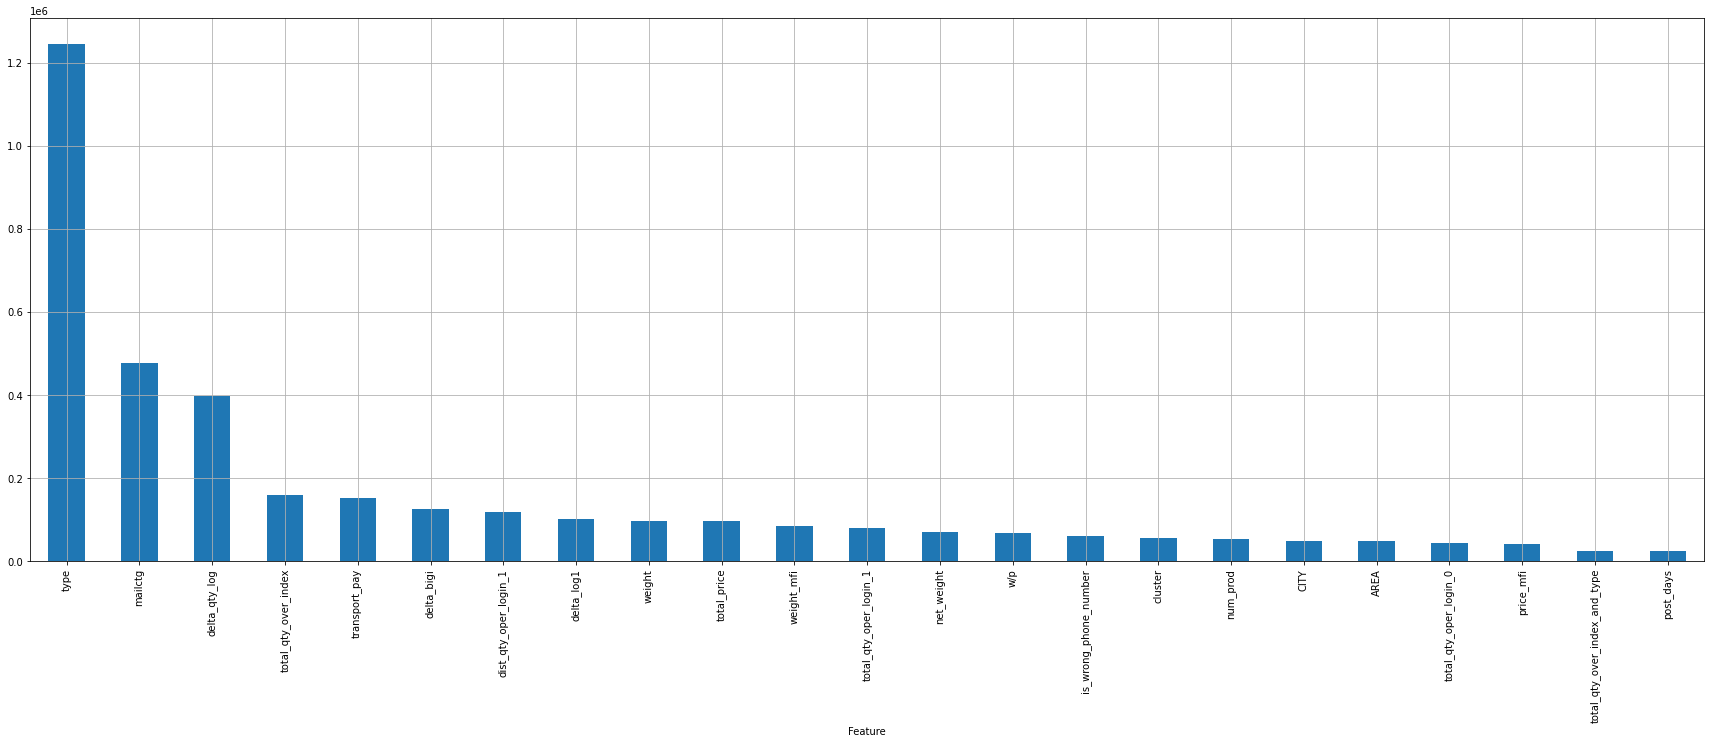

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

CPU times: user 108 ms, sys: 25.6 ms, total: 134 ms
Wall time: 206 ms


<AxesSubplot:xlabel='Feature'>

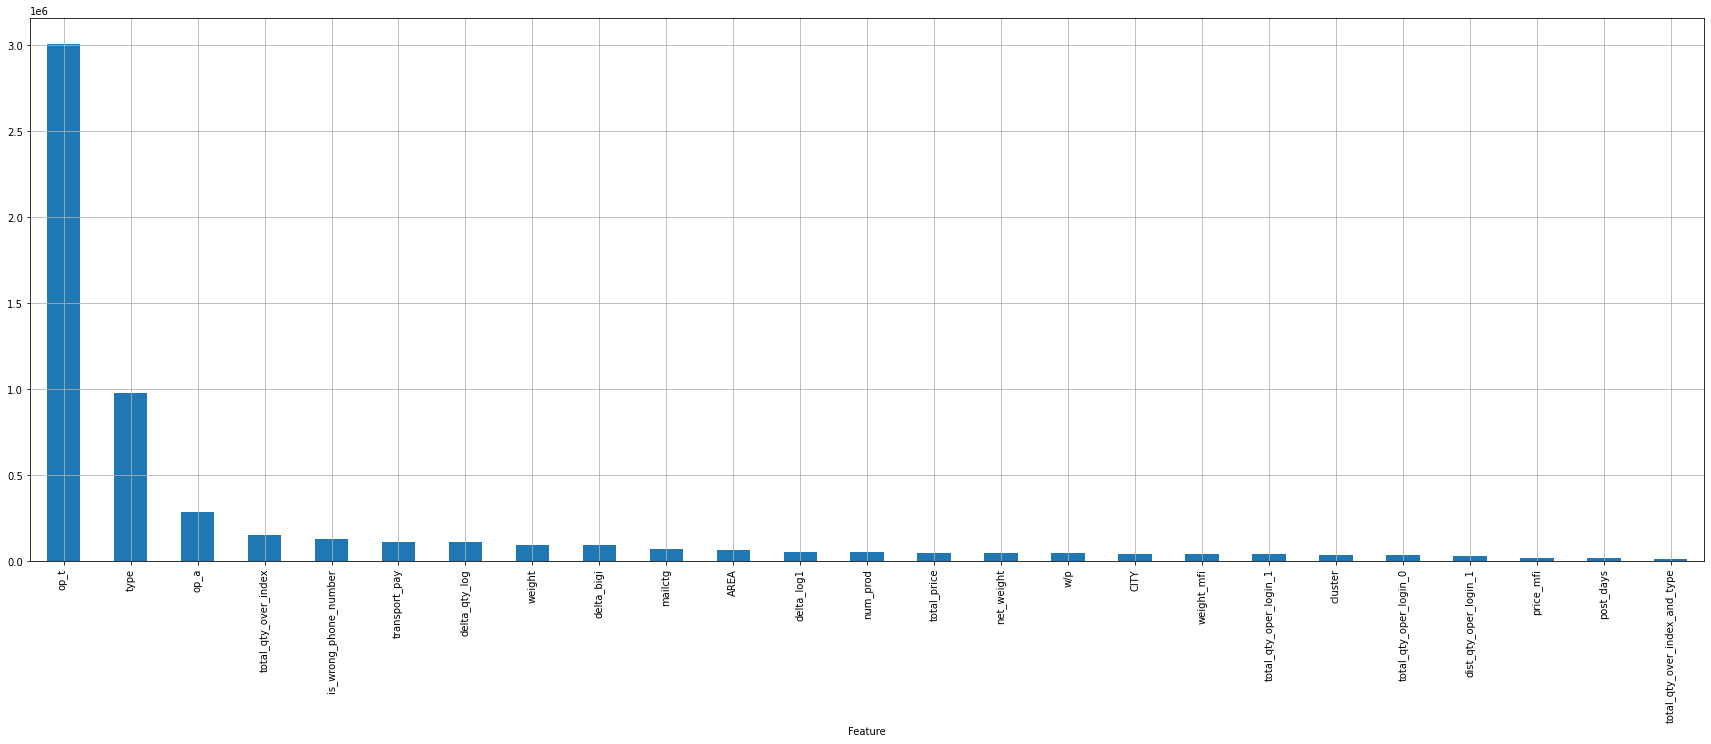

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
import joblib

joblib.dump(automl, 'model_911_bez1.pkl')

['model_911_bez1.pkl']

In [ ]:
te_pred = automl.predict(te_data)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(te_data['label'].values,te_pred.data[:,0])

0.95171376087469

In [ ]:
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score

In [ ]:


metric = pd.DataFrame(columns = ['alpha','precision','recall','f1','accuracy','roc_auc','macro_recall','ovo_auc'])

for x in np.array(list(range(20)))/100 :
    row = []
    tr = te_data['label'].values
    pr = 1*(te_pred.data[:,0] >= x)
    row.append(x)

    row.append(precision_score(te_data['label'].values ,pr))
    row.append(recall_score(te_data['label'].values ,pr))
    row.append(f1_score(te_data['label'].values ,pr))
    row.append(accuracy_score(te_data['label'].values ,pr))
    

    fp = np.sum((pr == 1) & (tr == 0))
    tp = np.sum((pr == 1) & (tr == 1))

    fn = np.sum((pr == 0) & (tr == 1))
    tn = np.sum((pr == 0) & (tr == 0))

    fpr = (fp / (fp + tn))
    tpr = (tp / (tp + fn))

    roc = (1+ tpr - fpr)/2 


    row.append(roc)
    row.append(recall_score(te_data['label'].values ,pr, average = "macro" ))
    row.append(roc_auc_score(te_data['label'].values ,pr, multi_class='ovo'))

    metric.loc[len(metric.index)] = row



In [ ]:
metric

,alpha,precision,recall,f1,accuracy,roc_auc,macro_recall,ovo_auc
0,0.00,0.028608,1.000000,0.055625,0.028608,0.500000,0.500000,0.500000
1,0.01,0.106733,0.981620,0.192531,0.764446,0.869835,0.869835,0.869835
2,0.02,0.128839,0.960559,0.227204,0.813063,0.884639,0.884639,0.884639
3,0.03,0.140055,0.944800,0.243948,0.832461,0.886976,0.886976,0.886976
4,0.04,0.154252,0.919837,0.264199,0.853424,0.885653,0.885653,0.885653
5,0.05,0.171805,0.885028,0.287751,0.874658,0.879690,0.879690,0.879690
6,0.06,0.195567,0.840518,0.317306,0.896529,0.869349,0.869349,0.869349
7,0.07,0.218367,0.797000,0.342810,0.912578,0.856491,0.856491,0.856491
8,0.08,0.242219,0.759161,0.367259,0.925164,0.844607,0.844607,0.844607
9,0.09,0.262324,0.726828,0.385511,0.933712,0.833317,0.833317,0.833317


In [ ]:
def op_t(x):
    return x[:x.find('_')]
def op_a(x):
    return x[x.find('_')+1:]

In [ ]:
qq =  pd.read_csv('./PIndx20.csv')
qq['index_oper'] = qq['INDEX'].values



def p_to_int(x):
    if type(x) == float:
        return int(x)
    return x[:x.find('.')]

#df['index_oper'] = df['index_oper'].apply(p_to_int)
def nd(x):
    if x == '':
        return 0
    x = int(x)
    if x // 10**5 >0:
        return 6
    elif x // 10**4 >0:
        return 5
    elif x // 10**3 >0:
        return 4

def from5t6(x):
    if x == '':
        return 0
    x = int(x)
    if x // 10**5 == 0:
        return x*10
    return x

In [ ]:
test_df = pd.read_csv('./test_dataset_test.csv')
test_df["is_in_yandex"] = pd.Categorical(test_df["is_in_yandex"])
test_df["is_in_yandex"].astype('category').cat.codes
test_df["is_in_yandex"] = test_df["is_in_yandex"].cat.codes

test_df["is_return"] = pd.Categorical(test_df["is_return"])
test_df["is_return"].astype('category').cat.codes
test_df["is_return"] = test_df["is_return"].cat.codes

test_df['op_t'] = test_df['oper_type + oper_attr'].apply(op_t).astype('int64')
test_df['op_a'] = test_df['oper_type + oper_attr'].apply(op_a).astype('int64')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
test_df['index_oper'] = test_df['index_oper'].apply(p_to_int)


pld2 = pd.DataFrame(columns = ['index_oper','new_index_oper','OPSSUBM','REGION','AUTONOM','CITY','ACTDATE'])
pld = pd.DataFrame(columns = ['index_oper','new_index_oper'])
pld['index_oper'] = test_df['index_oper'].values
pld2['index_oper'] = test_df['index_oper'].values
qq['new_index_oper'] = qq['INDEX'].values

for i in range(10):
    def from5t6(x):
        if x == '':
            return 0
        x = int(float(x))
        if x // 10**5 == 0:
            return x*10 + i
        return x
    pld['new_index_oper'] = pld['index_oper'].apply(from5t6)
    pld2['new_index_oper'] = pld2['index_oper'].apply(from5t6)
    
    pz = pd.merge(pld, qq[['new_index_oper','OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']],how = 'left', on="new_index_oper")
    
    pld['index_oper'][pz['ACTDATE'].isna() == False]['index_oper'] = pz[pz['ACTDATE'].isna() == False]['new_index_oper'].values
    pld2['index_oper'][pz['ACTDATE'].isna() == False]['index_oper'] = pz[pz['ACTDATE'].isna() == False]['new_index_oper'].values
    #pld[['OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']] = pz[pz['ACTDATE'].isna() == False][['OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']].values
    pld2.loc[pz['ACTDATE'].isna() == False,['OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']] = pz[pz['ACTDATE'].isna() == False][['OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']].values


pld2['AREA'] = (pld2['REGION'].fillna('') + pld2['AUTONOM'].fillna('')).values
pld2.drop(['REGION','AUTONOM'],axis = 1,inplace = True)
pld2.loc[pld2['AREA'] == 'МОСКВА','CITY'] = pld2[pld2['AREA'] == 'МОСКВА']['CITY'].fillna('МОСКВА').values

big_test_df = pd.concat([test_df,pld2.drop(['index_oper'],axis=1)],axis = 1)
big_test_df['ACTDATE'] = pd.to_datetime(big_test_df['ACTDATE'])


def npust(x):
    if x == '':
        return 0
    return int(x)

    
big_test_df['index_oper'] = big_test_df['index_oper'].apply(npust)
big_test_df['new_index_oper'] = big_test_df['new_index_oper'].apply(npust)
big_test_df['OPSSUBM'] = big_test_df['OPSSUBM'].fillna(0).apply(npust)

big_test_df['net_weight'] = (big_test_df['weight'] - big_test_df['weight_mfi'])
big_test_df['total_price'] = (big_test_df['price_mfi'] + big_test_df['transport_pay'])

big_test_df['w/p'] = np.log(big_test_df['weight_mfi'] + 1) - np.log(big_test_df['price_mfi']+1)

big_test_df['post_days'] = pd.to_datetime('2020-11-1') - pd.to_datetime(big_test_df['ACTDATE'])
big_test_df['post_days'] = big_test_df['post_days'].apply(lambda x: x.days)


big_test_df['delta_log1'] = np.log(big_test_df['total_qty_oper_login_1']+1) - np.log(big_test_df['dist_qty_oper_login_1']+1)

big_test_df['delta_qty_log'] = (big_test_df['total_qty_oper_login_1'] - big_test_df['total_qty_oper_login_0'])

big_test_df['delta_bigi'] = (big_test_df['total_qty_over_index'] - big_test_df['total_qty_over_index_and_type'])

def num_tov(x):
    if x == '0' or x=='':
        return 0
    else:
        return x.count(',')+1
    

big_test_df['num_prod'] = big_test_df['name_mfi'].apply(num_tov)

In [ ]:
5*8

40

In [ ]:
del tr_data

In [ ]:
test_cluster = pd.read_csv('./test_clusters.csv')

In [ ]:
big_test_df['cluster'] = test_cluster['cluster'].values

In [ ]:
del test_cluster

In [ ]:
big_test_df['op_t'] = big_test_df['oper_type + oper_attr'].apply(op_t).astype('int64')
big_test_df['op_a'] = big_test_df['oper_type + oper_attr'].apply(op_a).astype('int64')

In [ ]:
big_test_df.drop(['name_mfi','oper_type + oper_attr','ACTDATE','is_privatecategory','is_in_yandex','mailtype','is_wrong_sndr_name','is_wrong_address','is_return','priority','directctg','class','is_wrong_rcpn_name','index_oper','new_index_oper','OPSSUBM'],axis = 1,inplace = True)

In [ ]:
end_test_pred = automl.predict(big_test_df)

In [ ]:
end_test_pred

array([[7.9575159e-02],
       [2.0653152e-01],
       [3.0362045e-02],
       ...,
       [1.7602635e-05],
       [3.0337245e-05],
       [7.1519311e-03]], dtype=float32)

In [ ]:
sum(1*(end_test_pred.data[:,0] >= 0.05))

588018

In [ ]:
submission = pd.DataFrame(columns = ['id','label'])
submission['id'] = test_df['id'].values
submission['label'] = 1*(end_test_pred.data[:,0] >= 0.05)


In [ ]:
submission['label'].value_counts()

0    3411982
1     588018
Name: label, dtype: int64

In [ ]:
submission.to_csv('submission_9_11_05_2.csv',index = False)

# Special

In [ ]:
automl.get_feature_scores('fast')

,Feature,Importance
0,type,1.245929e+06
1,mailctg,4.767929e+05
2,delta_qty_log,3.977020e+05
3,total_qty_over_index,1.602480e+05
4,transport_pay,1.517017e+05
5,delta_bigi,1.270496e+05
6,dist_qty_oper_login_1,1.182451e+05
7,delta_log1,1.006862e+05
8,weight,9.752177e+04
9,total_price,9.648345e+04


# NLP hahahahahhahah